# 1. Imports

# Hi there!

In [ ]:
import pandas as pd # dataframes
from sklearn.preprocessing import RobustScaler # scale to zero mean and unit variance
from sklearn.decomposition import PCA # primary component analysis
from sklearn.ensemble import IsolationForest,RandomForestRegressor
import matplotlib.pyplot as plt # plots
from sklearn import set_config # return pd.DataFrame from transformers
import pickle # move transformers and estimators between notebooks
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.neighbors import KNeighborsRegressor
# custom helper functions
from helper_functions import feature_distribution_plot, scree_plot, decision_boundary_plot, imputation_and_accuracy

<hr> 

# 2. Settings

In [ ]:
set_config(transform_output='pandas')

<hr> 

# 3. Preprocess the Data Set

## 3.1 General Preprocessing

In [ ]:
df = pd.read_csv('./data/hcvdat22_Clustering.csv')

Some basic information on the dataset:

In [ ]:
df.info()

- there are 615 rows and 13 columns
- 5/13 columns have duplicate values
- we can drop the duplicate index and the categorical 'sex' column

# FRAGE: Dürfen wir Sex hier einfach raus nehmen?

Was sollen wir mit Age machen (categorisch/numerisch)

Falls nicht, dann LabelEncoder einbauen

In [ ]:
df.drop(columns=['Unnamed: 0', 'Sex'], inplace=True)

Inspecting some rows of the data:

In [ ]:
df.head()

## 3.2 Data Distribution

In [ ]:
plot_feature_distribution = feature_distribution_plot(df=df, suptitle='Distributions of the Second Dataset')

Except for age, all features mostly seem to follow a gaussian distribution. However, all features contain outliers which are most noticeable for CREA and GGT. These outliers could represent people for medical conditions  not suitable for blood donation, which we aim to identify.

<hr> 

## 4. Impute Missing Values
- Estimate the accuracy of the imputation for each feature

## 4.1 Show and plot the missing values

How many rows with missing values are there?

In [ ]:
na_rows = df[df.isna().any(axis=1)]
len(na_rows)

Inspect all 26 rows with missing values:

In [ ]:
na_rows

In [ ]:
idx_na_rows = na_rows.index

- rows have up to 3/11 NaN values
- 18/26 instances from ALP are NaN
    - keep them because they're only (18/615) ~ 2 % of the original data
- neither columns nor rows get dropped
- missing values get imputed

Show the NAN values for each column

In [ ]:
df_nas = df.isnull()
df_nas_sum = df_nas.sum()
print("Sum of NAs in data:")
print(df_nas_sum)

In [ ]:
# Plotting the bar chart
fig, ax = plt.subplots()
bars = plt.bar(df_nas_sum.index, df_nas_sum)
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Sum of NAs in Each Column')
plt.xticks(rotation=45, ha='right')  # Rotating x-axis labels for better visibility

# Adding counts on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', color='black')

plt.show()

## 4.2 Now impute the missing values using sklearn imputers

In [ ]:
# Create a DataFrame without NaN values
df_no_nan = df.dropna().copy()

# Split the data into training and test sets
train_data, test_data = train_test_split(df_no_nan, test_size=0.2, random_state=42)

rf_estimator = RandomForestRegressor(n_estimators=10)
knn_estimator = KNeighborsRegressor(n_neighbors=5)

imputer_dict = {
    'mean': SimpleImputer(strategy='mean'),
    'median': SimpleImputer(strategy='median'),
    'iterative_rf': IterativeImputer(estimator=rf_estimator),
    'iterative_knn': IterativeImputer(estimator=knn_estimator),
    'knn': KNNImputer(n_neighbors=5, weights='distance')
}

# Call the function with train and test data
accuracy_results = imputation_and_accuracy(train_data, test_data, df_no_nan.columns, imputer_dict)

# Display the accuracy results DataFrame
accuracy_results


<hr>

# FRAGE: Müssen wir diskutieren welchen imputer wir nehmen und warum

## 4.3 Perform actual Imputation

In [ ]:
iterative_imputer_rf = imputer_dict["iterative_rf"]# TODO: either add indicator or save missing_indicator separately
df_imputed = iterative_imputer_rf.fit_transform(df)

Are there any missing values left?

In [ ]:
len(df_imputed[df_imputed.isna().any(axis=1)])

<hr>

## 5. Scaling
Scale the features to zero mean and unit variance using a robust scaling approach to control for the effect of outliers and different scales:

In [ ]:
scaler = RobustScaler() # instantiate scaler
df_scaled = scaler.fit_transform(df_imputed) # fit the scaler create scaled data

Inspect the scaled features:

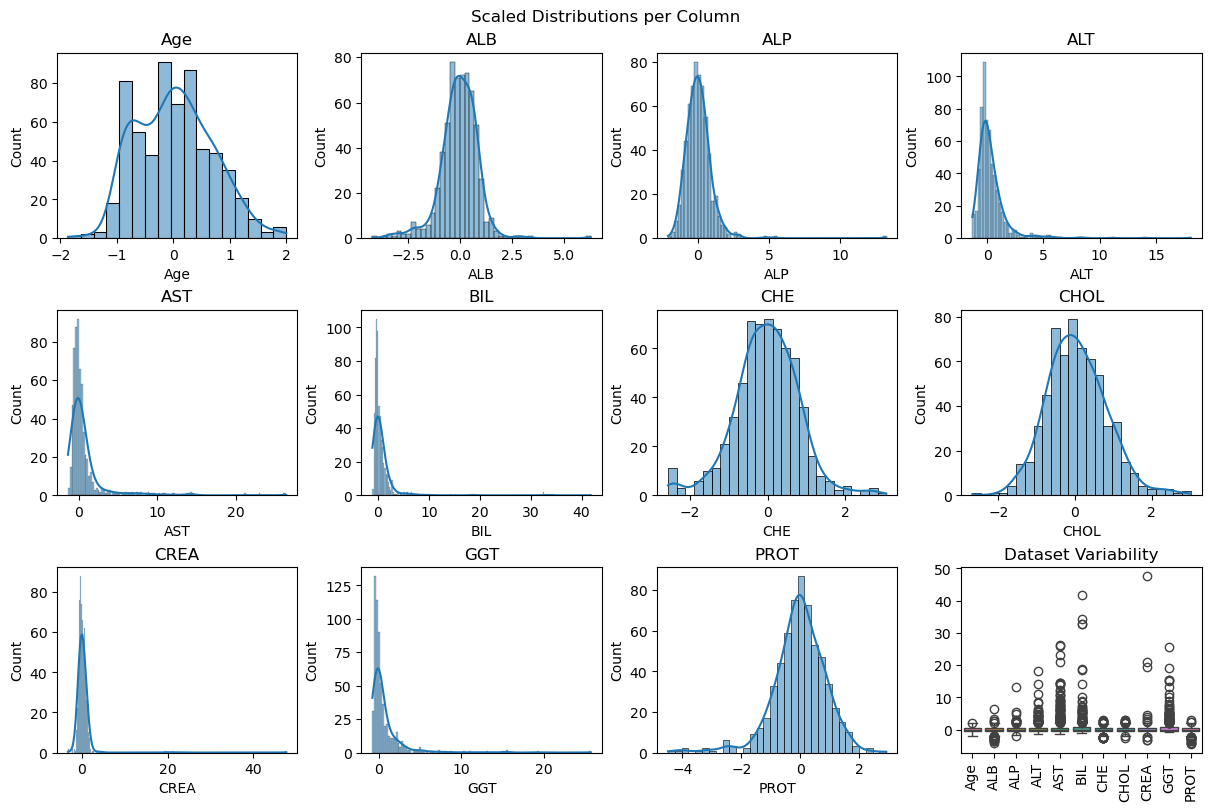

In [ ]:
plot_feature_distribution_scaled = feature_distribution_plot(df=df_scaled, suptitle='Scaled Distributions per Column')

The distributions look the same but in the dataset variability plot, we can observe how the scale has narrowed down significantly, making the pca less susceptible to outliers.

# Principal Component Analysis
- Transform the data into the principal components from phase one
- Would it make sense to retrain the PCA for the new data?
    - Yes, since the PCA is dependant on the data's distribution which has changed between phases one and two

## Using the original (old) PCA

In [ ]:
# import the pca from phase one
with open('./pickle/pca_phase_one.pkl', 'rb') as file:
    pca_phase_one = pickle.load(file)

In [ ]:
df_pca_phase_one = pca_phase_one.transform(df_scaled)

## Training a new PCA

In [ ]:
N_COMPONENTS = 11
pca_phase_two = PCA(n_components=N_COMPONENTS)

In [ ]:
df_pca_phase_two = pca_phase_two.fit_transform(df_scaled)

## Comparing Principal Components

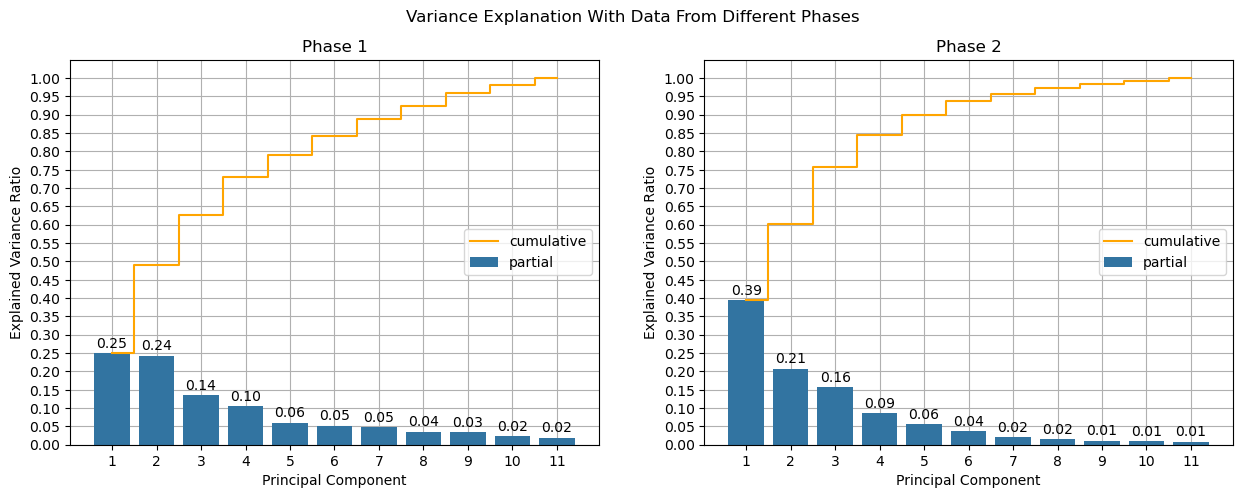

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

scree_plot(ax1, pca_phase_one, 'Phase 1')
scree_plot(ax2, pca_phase_two, 'Phase 2')

plt.suptitle('Variance Explanation With Data From Different Phases')

plt.show()

# Perform a Cluster Analysis
-Compare and discuss the results of the Anomaly Detection & Cluster Analysis

In [ ]:
# import the fitted isolation forest
with open('./pickle/isolation_forest_phase_one.pkl', 'rb') as file:
    isolation_forest_phase_one = pickle.load(file)

In [ ]:
first_two_pcs_new = df_pca_phase_two.iloc[:,:2]
predictions = isolation_forest_phase_one.predict(first_two_pcs_new)
df_pca_phase_two['outlier'] = predictions

In [ ]:
df_pca_phase_two

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,outlier
0,-1.449403,1.054297,1.072691,-1.144239,-1.118733,0.798855,-1.166568,0.665822,0.848189,-0.159409,-0.293891,1
1,-1.883192,0.137727,-0.346430,-0.372716,-0.177291,-0.478266,0.146717,0.352008,1.231068,-0.737081,-0.913859,1
2,0.131029,-1.575917,-0.050313,-1.073537,0.666282,-1.235437,-0.127626,0.922660,0.473457,-0.413508,0.152060,1
3,0.198358,1.600656,-0.064283,0.199239,0.489702,-0.428674,-1.169300,0.406524,0.339904,-0.538053,0.052088,1
4,-0.829371,0.426336,-0.161149,0.201537,0.250445,0.698185,-0.330015,0.451756,1.236366,-0.055423,-0.153943,1
...,...,...,...,...,...,...,...,...,...,...,...,...
610,17.606285,-9.657586,4.181430,19.401747,-6.873508,-0.779497,4.672464,4.786325,1.166526,0.186015,0.581890,-1
611,1.898512,0.912213,-0.860943,-0.281358,-2.386814,2.611794,0.535368,1.785448,-1.402632,-1.025575,-1.073077,1
612,8.432940,0.773647,-1.375910,-1.803202,-1.980451,0.248507,0.557986,1.576769,-1.850568,-1.411804,-1.124616,-1
613,2.864047,-0.659447,-1.673565,-0.533474,-0.261070,1.560762,-0.550220,0.741525,-0.532670,-0.801253,0.052807,1


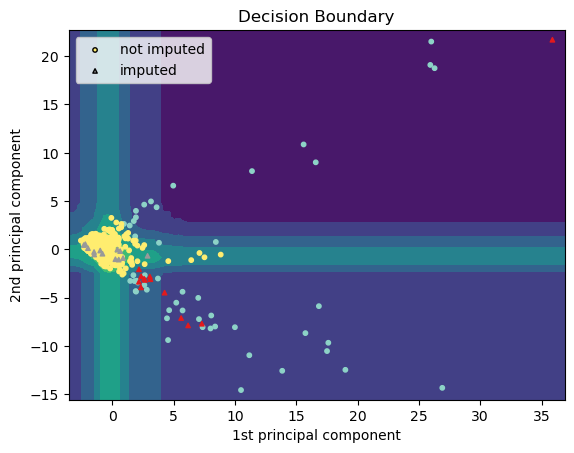

In [ ]:
plot_decision_boundary = decision_boundary_plot(df=df_pca_phase_two, estimator=isolation_forest_phase_one, imputed_rows=idx_na_rows)

## TODO: Discussion

# FRAGE: Passt das so mit den Dreiecken udn den Kreisen oder was ist gemeint mit different marker style